In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [7]:
# Autoencoder architecture
input_img = Input(shape=(224, 224, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [8]:
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [9]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 8)         584 

In [11]:
data_dir = "../StanfordCarDataset"
train_resized_dir = f"{data_dir}/resized_dataset_train"
test_resized_dir = f"{data_dir}/resized_dataset_test"
noisy_dataset_train_dir = f"{data_dir}/noisy_dataset_train"
noisy_dataset_test_dir = f"{data_dir}/noisy_dataset_test"

In [12]:
# Function to add noise to images
def add_noise(image):
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

In [74]:
def create_noisy_images_from_set(source_directory, noisy_directory):
    for filename in os.listdir(source_directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(source_directory, filename)
            img = cv2.imread(img_path)
            noisy_img = add_noise(img)
            noisy_img_path = os.path.join(noisy_directory, filename)
            cv2.imwrite(noisy_img_path, noisy_img)

create_noisy_images_from_set(train_resized_dir, noisy_dataset_train_dir)
create_noisy_images_from_set(test_resized_dir, noisy_dataset_test_dir)

In [13]:
def fetch_images_as_nparray(directory, max_images=-1):
    np_images = []
    count = 0
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # if len(img.shape) == 2:  # Convert grayscale to RGB
                #     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                np_images.append(img)
            
                count += 1
                if max_images > 0 and count >= max_images:
                    break
    return np_images

# import math
def expand_grayscale(image):
    return np.expand_dims(image, axis=-1)

max_train_images = 1000
max_validation_images = round(max_train_images*0.2)

x_train_noisy = np.array(fetch_images_as_nparray(noisy_dataset_train_dir, max_images=max_train_images))
x_test_noisy = np.array(fetch_images_as_nparray(noisy_dataset_test_dir, max_images=max_validation_images))
x_train = np.array(fetch_images_as_nparray(train_resized_dir, max_images=max_train_images))
x_test = np.array(fetch_images_as_nparray(test_resized_dir, max_images=max_validation_images))

In [14]:

print(x_train_noisy.shape)
print(x_test_noisy.shape)
print(x_train.shape)
print(x_test.shape)



(1000, 224, 224, 3)
(200, 224, 224, 3)
(1000, 224, 224, 3)
(200, 224, 224, 3)


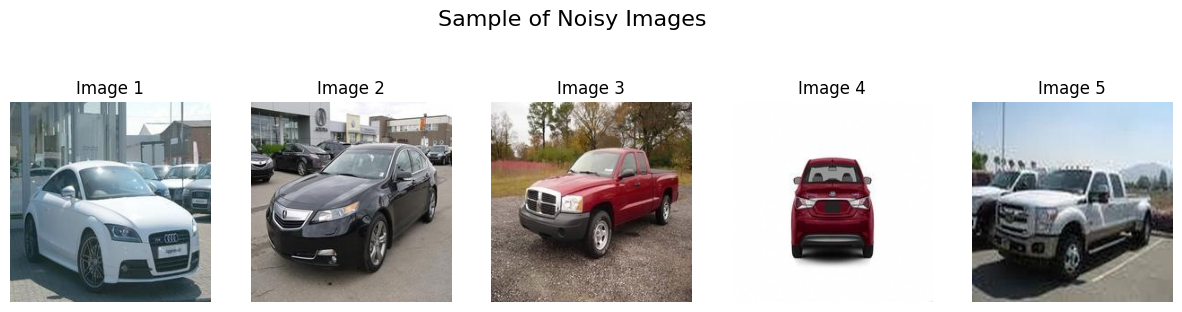

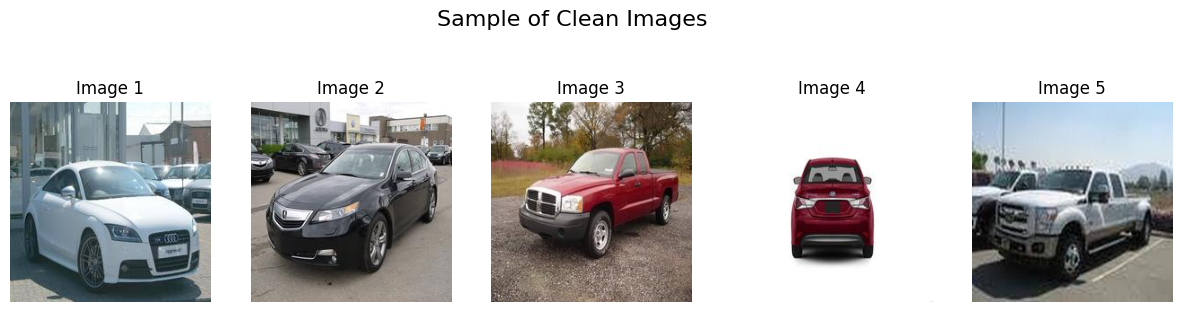

In [20]:
def plot_images(images, title):
    plt.figure(figsize=(15, 7))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Image {i + 1}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

noisy_sample = x_train_noisy[:5]
clean_sample = x_train[:5]

plot_images(noisy_sample, "Sample of Noisy Images")
plot_images(clean_sample, "Sample of Clean Images")

In [15]:
x_train_expanded = np.expand_dims(x_train, axis=0)
x_train_expanded = np.repeat(x_train_expanded, 128, axis=0)
x_train_noisy_expanded = np.expand_dims(x_train_noisy, axis=0)
x_train_noisy_expanded = np.repeat(x_train_noisy_expanded, 128, axis=0)
# print(x_train_expanded.shape)
print(x_train_noisy_expanded.shape)

x_train_noisy_expanded = x_train_noisy_expanded.astype('float32') / 255.0
x_train_expanded = x_train_expanded.astype('float32') / 255.0

# Create noisy and clean validation datasets
x_val_noisy = x_train_noisy[:100]
x_val_clean = x_train[:100]

MemoryError: Unable to allocate 17.9 GiB for an array with shape (128, 1000, 224, 224, 3) and data type uint8

In [17]:
# Train the autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/50

8/8 [==============================] - 72s 6s/step - loss: 302.4636 - val_loss: -582.0649
Epoch 2/50
8/8 [==============================] - 28s 4s/step - loss: -1889.5176 - val_loss: -5755.1445
Epoch 3/50
8/8 [==============================] - 26s 3s/step - loss: -17442.6543 - val_loss: -51550.4102
Epoch 4/50
8/8 [==============================] - 22s 3s/step - loss: -143538.1875 - val_loss: -393509.7500
Epoch 5/50
8/8 [==============================] - 28s 4s/step - loss: -987373.0000 - val_loss: -2504013.2500
Epoch 6/50
8/8 [==============================] - 27s 3s/step - loss: -5775651.0000 - val_loss: -13942852.0000
Epoch 7/50
8/8 [==============================] - 27s 3s/step - loss: -29366806.0000 - val_loss: -66448240.0000
Epoch 8/50
8/8 [==============================] - 34s 4s/step - loss: -131766472.0000 - val_loss: -279027808.0000
Epoch 9/50
8/8 [==============================] - 30s 4s/step - loss: -519017248.0000 - val_loss: -1040609088.0000
Epoch 10/50
8/8 [==